In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2023-06-18 09:18:41.003703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Package for querying the IBM Quantum API
import requests
import numpy as np
import seaborn as sns

# Load all the basic Qiskit functionality
from qiskit import *
# Get the properties and configuarition classes used to define the data for a Qiskit backend
from qiskit.providers.models import BackendProperties, QasmBackendConfiguration
# The 'fake' Qiskit backend class
from qiskit.providers.fake_provider import FakeBackend

# Plotting routines
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
try:
    plt.style.use('quantum-light')
except:
    pass

In [3]:
def fake_backend_from_properties(props):
    """Return a FakeBackend from a BackendProperties object
    
    Parameters:
        props (BackendProperties): A backend properties instance
        
    Returns:
        FakeBackend: A fake backend matching the given properties data
        
    Raises:
        ValueError: Could not determine the two-qubit basis gate type
    """
    # Generate the set of basis gates from the gate info in the properties
    basis_gates = set()
    for gate in props.gates:
        basis_gates.add(gate.gate)
    basis_gates = list(basis_gates)
    
    # Determine the two-qubit entangling gate used to generate the coupling map
    two_qubit_gate = None
    if 'cx' in basis_gates:
        two_qubit_gate = 'cx'
    elif 'ecr' in basis_gates:
        two_qubit_gate = 'ecr'
    elif 'cz' in basis_gates:
        two_qubit_gate = 'cz'
    else:
        raise ValueError('I do not know what 2Q gate the backend is using')
    # Iterate over the two-qubit gates to obtain the coupling map
    coupling_map = []
    for gate in props.gates:
        if gate.gate == two_qubit_gate:
            coupling_map.append(gate.qubits)
    # Form a configuration object from the data in the properties
    config = QasmBackendConfiguration(backend_name=props.backend_name,
                                      backend_version=props.backend_version,
                                      n_qubits=len(props.qubits),
                                      basis_gates=basis_gates,
                                      gates=basis_gates, # This is not really valid, but not using it
                                      local=True,
                                      simulator=False,
                                      conditional=True,
                                      open_pulse=False,
                                      memory=True,
                                      max_shots=None,
                                      coupling_map=coupling_map)

    # Overload the properties method on the FakeBackend to return our properties
    def properties():
        return props

    # Form the actual FakeBackend to return 
    fake_backend = FakeBackend(config)
    fake_backend.properties = properties

    return fake_backend

In [4]:
props_res2 = requests.get('https://api-qcon.quantum-computing.ibm.com/api/Backends/ibm_sherbrooke/properties')
if not props_res2.json().get('backend_name', None): raise Exception('Request failed')
    
props2 = BackendProperties.from_dict(props_res2.json())
fake_backend2 = fake_backend_from_properties(props2)

In [5]:
from qiskit_aer.noise import NoiseModel
#from qiskit_aer import aer_simulator
#dev = qml.device('qiskit.aer', wires=2, backend='aer_simulator_density_matrix')
noise_model = NoiseModel.from_backend(fake_backend2)
#backend = aer_simulator(method='density_matrix',noise_model=noise_model)
dev = qml.device('qiskit.aer', wires=2, noise_model = noise_model)

dev_n = qml.device(
        "qiskit.aer",
        wires=2,
        shots=1000,
        noise_model=noise_model,
        backend="aer_simulator_statevector",
        seed_simulator=1,
        seed_transpiler=1,
    )


In [6]:
from qiskit_aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(fake_backend2)
dev_n = qml.device(
        "qiskit.aer",
        wires=2,
        shots=1000,
        noise_model=noise_model,
        backend="aer_simulator_statevector",
        seed_simulator=1,
        seed_transpiler=1,
    )


In [7]:
def real2():
    qml.SX(wires=1)
    qml.S(wires=1)

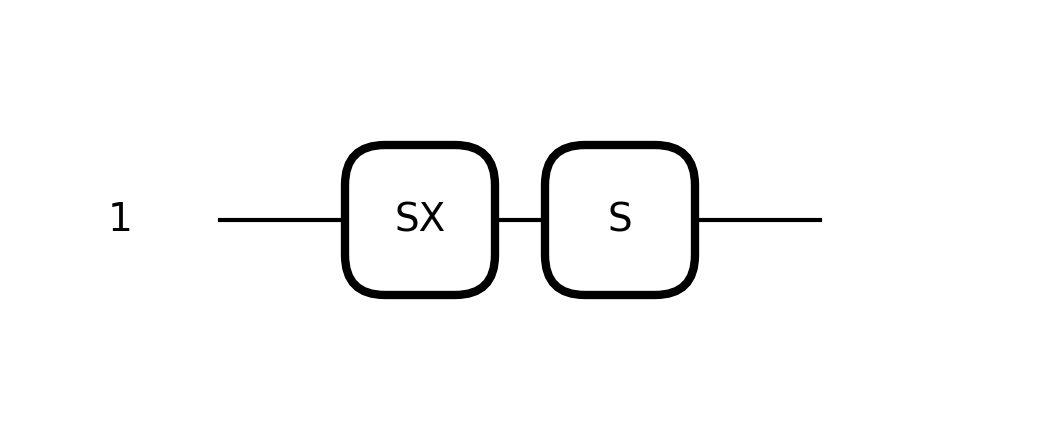

In [8]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(real2)()
plt.show()
#print(qml.draw(real2)())

In [9]:
def generator(w,**kwargs):
    qml.RZ(w[0],wires=0)
    qml.RX(w[1],wires=0)
    qml.RZ(w[2],wires=0)

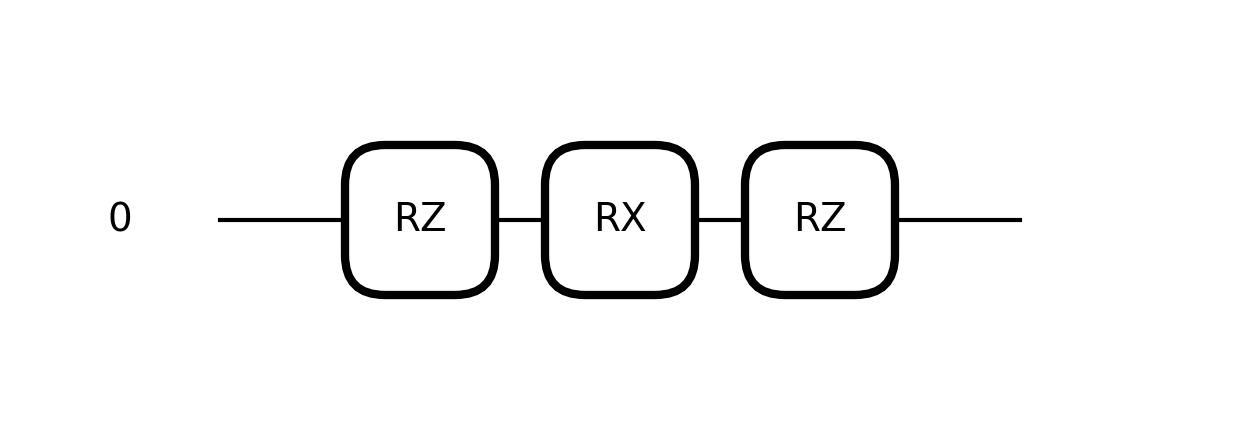

0: ──RZ(0.00)──RX(0.00)──RZ(0.00)─┤  


In [10]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(generator)(['t1','t2','t3'])
plt.show()
print(qml.draw(generator)([ 0,0,0]))

In [11]:
def discriminator(w,**kwargs):
    qml.Hadamard(wires=0)
    qml.CZ(wires=[1, 0])
    qml.RZ(w[0],wires=1)
    qml.RZ(w[1],wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=0)

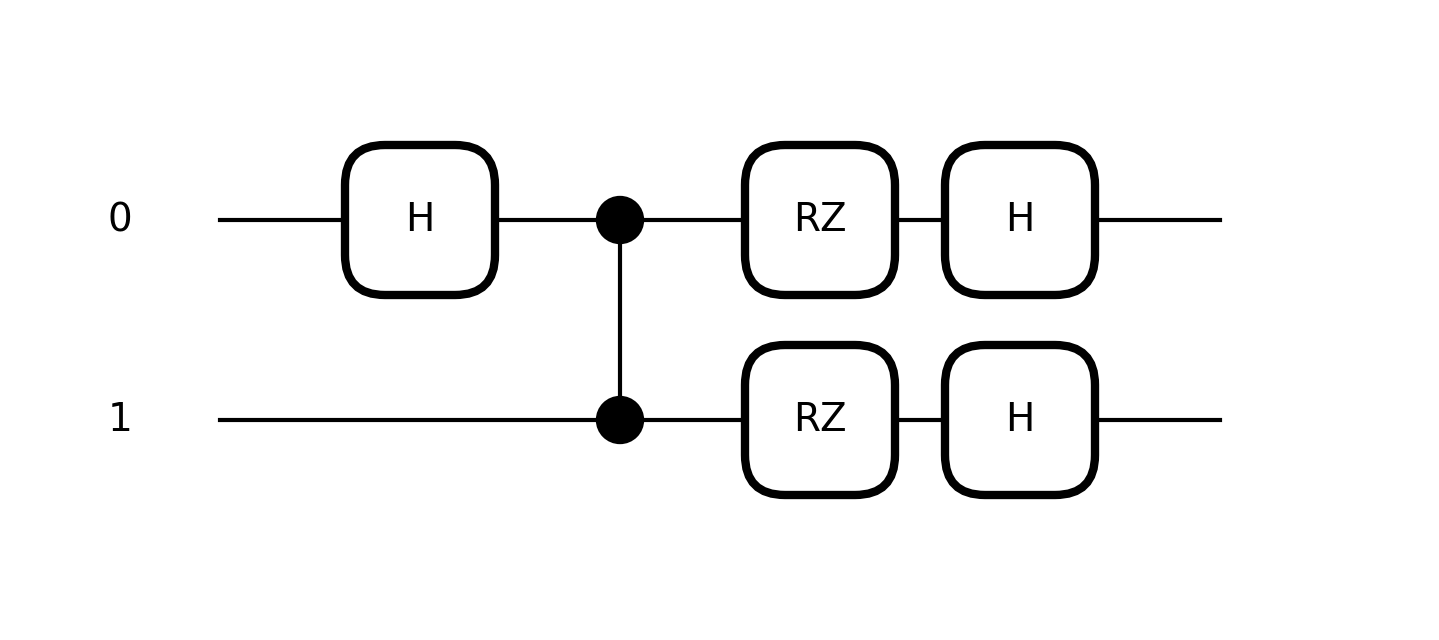

0: ──H─╭Z──RZ(0.00)──H─┤  
1: ────╰●──RZ(0.00)──H─┤  


In [12]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(discriminator)([ 0,0])
plt.show()
print(qml.draw(discriminator)([ 0,0]))

In [13]:
n = 1
wires = 2*n
qubits_a = range(0,n)
qubits_b = range(n,wires)

############################################
def swap_readout_op_penny(qubits_a, qubits_b):
    # it is P_0
    """Readout operation for variational swap test.

    Computes the bitwise and of matched qubits from qubits_a and qubits_b.

    Args:
        qubits_a:  The qubits system A act on
        qubits_b: The qubits system B act on
    """

    def _countSetBits(n):
        count = 0
        while n:
            count += n & 1
            n >>= 1
        return count

    def _one_proj(a):
        return (qml.Identity(a)-qml.PauliZ(a))/2

    if len(qubits_a) != len(qubits_b):
        raise ValueError("unequal system sizes.")

    ret_op = qml.Identity(range(0,wires))-qml.Identity(range(0,wires))
    for i in range(1 << len(qubits_a)):
        if _countSetBits(i) % 2 == 0:
            tmp_op = qml.Identity(range(0,wires))
            for j, ch in enumerate(bin(i)[2:].zfill(len(qubits_a))):
                intermediate = _one_proj(qubits_a[j]) @ _one_proj(qubits_b[j])
                if ch == '0':
                    intermediate = qml.Identity(qubits_a[j])@ qml.Identity(qubits_b[j]) - intermediate
                tmp_op = intermediate @ tmp_op
            ret_op = tmp_op + ret_op

    return ret_op

In [14]:
@qml.qnode(dev_n, interface='tf')
def real_gen_disc_circuit(gen_weights, disc_weights):
    real2()
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(swap_readout_op_penny(qubits_a, qubits_b))

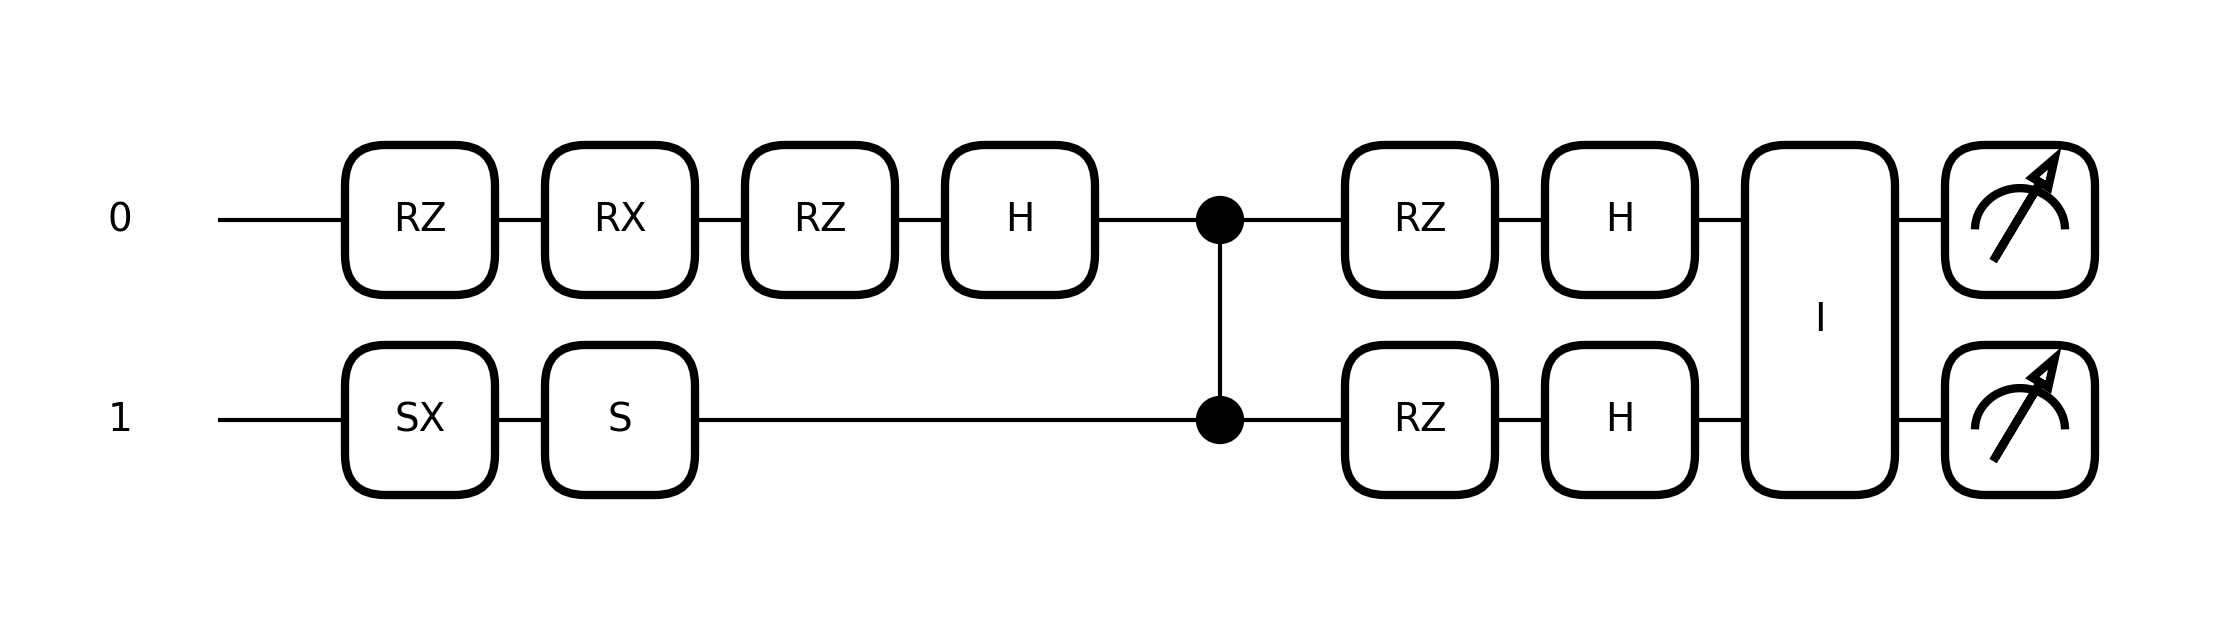

0: ──RZ(0.00)──RX(0.00)──RZ(0.00)──H─╭Z──RZ(0.00)──H─╭I─┤ ╭<𝓗>
1: ──SX────────S─────────────────────╰●──RZ(0.00)──H─╰I─┤ ╰<𝓗>


In [15]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(real_gen_disc_circuit)([ 0,0,0],[ 0,0])
plt.show()
print(qml.draw(real_gen_disc_circuit)([ 0,0,0],[ 0,0]))

In [16]:
def fid_discriminated(gen_weights,disc_weights):
    prob_0 = real_gen_disc_circuit(gen_weights, disc_weights)
    #convert to probability
    fid_output = 2*prob_0-1
    return fid_output

In [17]:
def disc_cost(disc_weights):
    cost = fid_discriminated(gen_weights,disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = 1-fid_discriminated(gen_weights,disc_weights)
    return cost

In [18]:
dev1 = qml.device('default.mixed', wires=2)
@qml.qnode(dev_n, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.density_matrix([0])
@qml.qnode(dev_n, interface="tf")
def circuit_rs():
    real2()
    return qml.density_matrix([1])

In [19]:
# train only generator while discriminator is a perfect swap frozen discriminator
####
dev1 = qml.device('default.mixed', wires=2)
@qml.qnode(dev1, interface="tf")
def circuit_rs1():
    real2()
    return qml.density_matrix([1])
####
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   #np.random.normal(scale=eps, size=(3,))
    
init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)


###############
loss_val_d = []
loss_val_g = []
#step_d = []
step_gf = []
sg_f =[]
epochs = 60
a = 1
for i in range(epochs): 
    #opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a)
            step_gf.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            state_fidelity = qml.math.fidelity(circuit_rs1(), circuit_gs(var_g))
            sg_f.append(state_fidelity)
            
perfect_swap = sg_f
perfect_step_g = step_gf

2023-06-18 09:19:54.460307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Step 0: cost = 0.508


/Applications/anaconda3/lib/python3.9/site-packages/pennylane/_qubit_device.py:981: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  warnings.warn(


Step 1: cost = 0.4970000000000001
Step 2: cost = 0.5109999999999999
Step 3: cost = 0.45899999999999985
Step 4: cost = 0.4700000000000002
Step 5: cost = 0.5349999999999999
Step 6: cost = 0.4889999999999999
Step 7: cost = 0.4820000000000002
Step 8: cost = 0.52
Step 9: cost = 0.565
Step 10: cost = 0.496
Step 11: cost = 0.51
Step 12: cost = 0.5009999999999999
Step 13: cost = 0.492
Step 14: cost = 0.5269999999999999
Step 15: cost = 0.44900000000000007
Step 16: cost = 0.41900000000000004
Step 17: cost = 0.40900000000000003
Step 18: cost = 0.4149999999999998
Step 19: cost = 0.3490000000000002
Step 20: cost = 0.2979999999999998
Step 21: cost = 0.262
Step 22: cost = 0.17900000000000005
Step 23: cost = 0.16399999999999992
Step 24: cost = 0.1140000000000001
Step 25: cost = 0.1100000000000001
Step 26: cost = 0.03600000000000003
Step 27: cost = 0.050999999999999934
Step 28: cost = 0.02499999999999991
Step 29: cost = 0.015000000000000124
Step 30: cost = 0.008999999999999897
Step 31: cost = 0.0099999

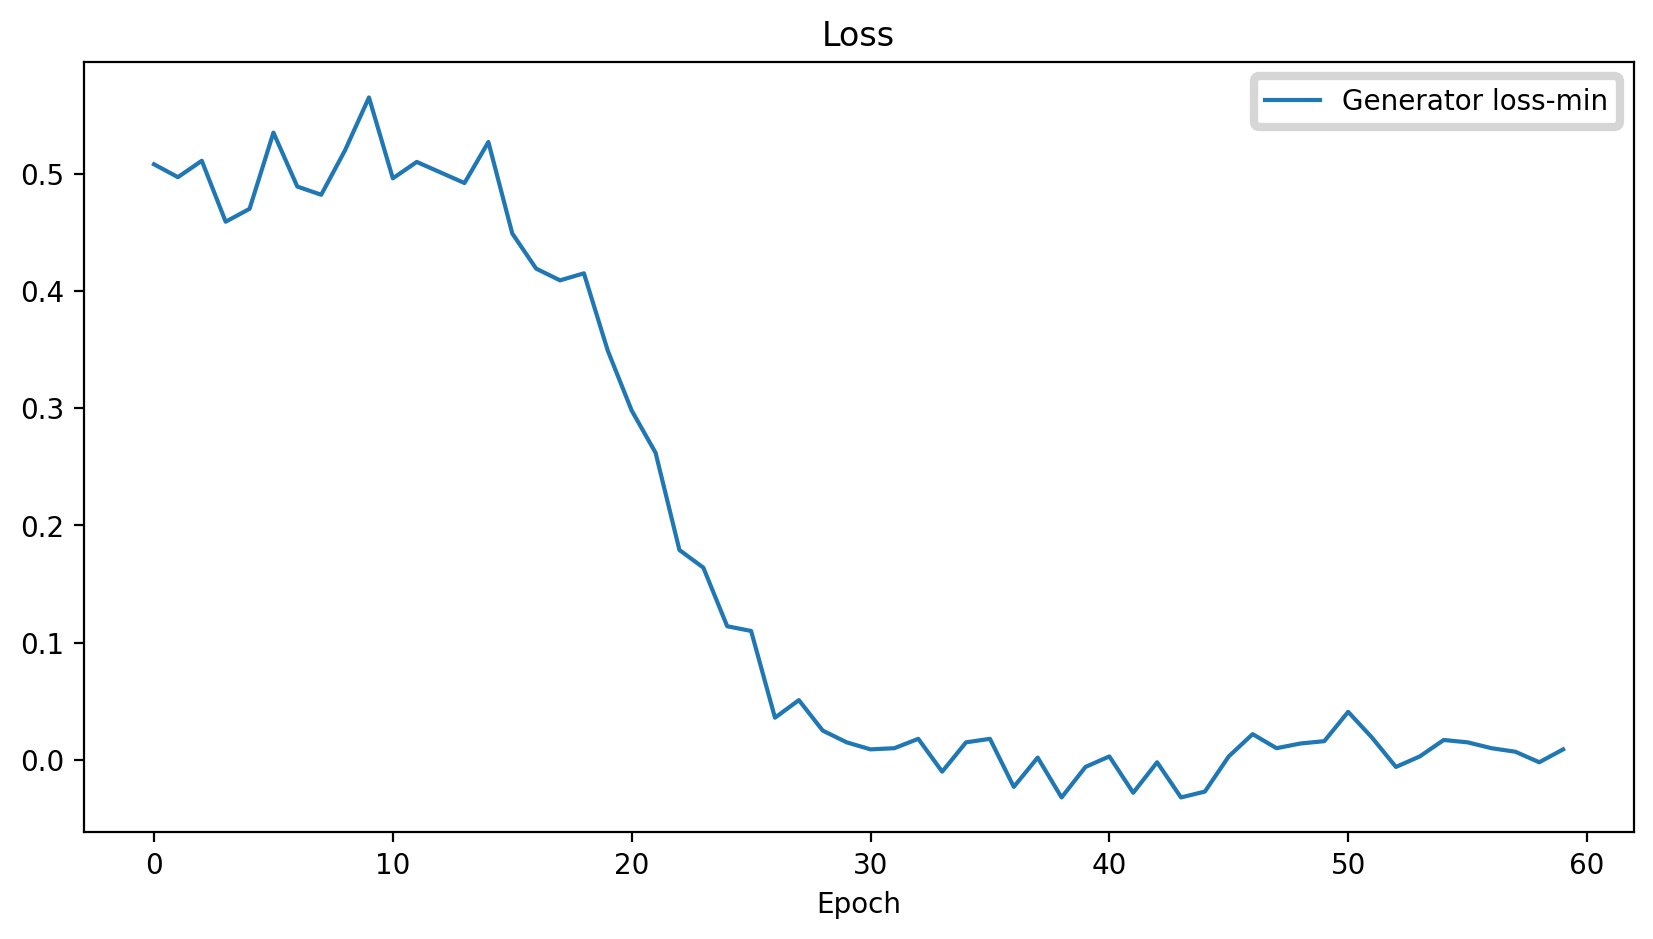

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_gf)), loss_val_g, label="Generator loss-min")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

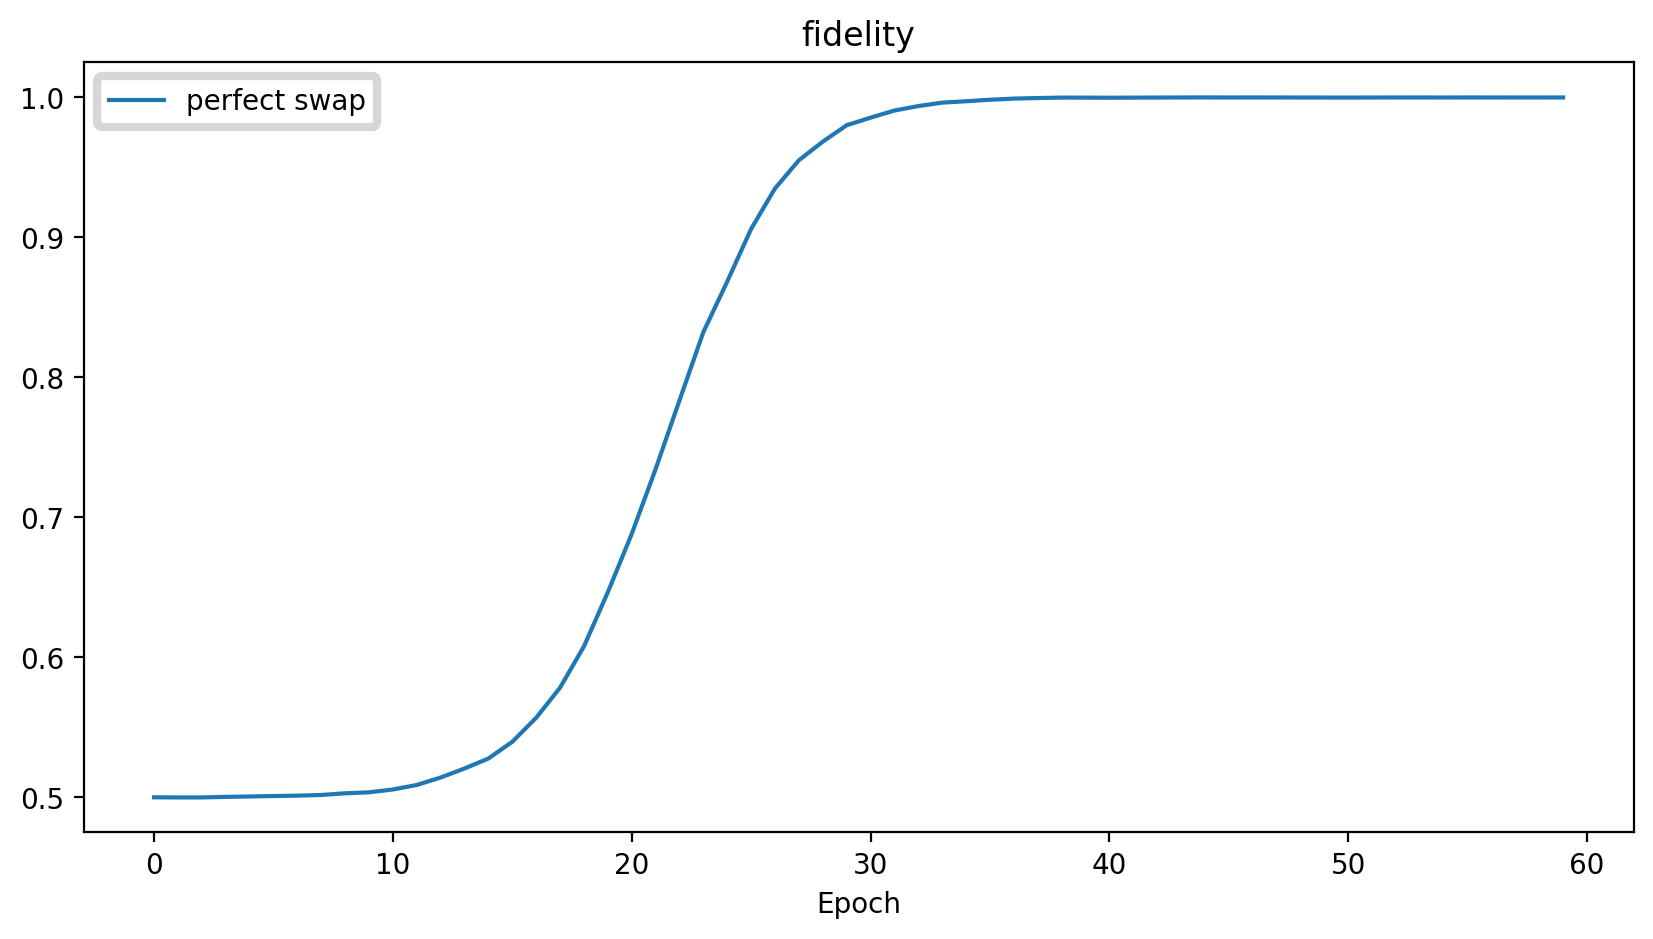

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [22]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 2) + \
                  # np.random.normal(scale=eps, size=(3,))    
init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 28
a1 = 1
for i in range(epochs1):            
    #opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs1(), circuit_gs(var_g))
            sg.append(state_fidelity)

#alternative training            
epochs2 = 20
a2 = 1
a3 = 1
for i in range(epochs2):
    #opt = tf.keras.optimizers.experimental.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs1(), circuit_gs(var_g))
            sg.append(state_fidelity) 
            
    #opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            #red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            #red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            #state_fidelity = qml.math.fidelity(red_r, red_g)
            state_fidelity = qml.math.fidelity(circuit_rs1(), circuit_gs(var_g))
            sg.append(state_fidelity)

Step 0: cost = 0.508
Step 1: cost = 0.4970000000000001
Step 2: cost = 0.5109999999999999
Step 3: cost = 0.45899999999999985
Step 4: cost = 0.4700000000000002
Step 5: cost = 0.5349999999999999
Step 6: cost = 0.4889999999999999
Step 7: cost = 0.4820000000000002
Step 8: cost = 0.52
Step 9: cost = 0.565
Step 10: cost = 0.496
Step 11: cost = 0.51
Step 12: cost = 0.5009999999999999
Step 13: cost = 0.492
Step 14: cost = 0.5269999999999999
Step 15: cost = 0.44900000000000007
Step 16: cost = 0.41900000000000004
Step 17: cost = 0.40900000000000003
Step 18: cost = 0.4149999999999998
Step 19: cost = 0.3490000000000002
Step 20: cost = 0.2979999999999998
Step 21: cost = 0.262
Step 22: cost = 0.17900000000000005
Step 23: cost = 0.16399999999999992
Step 24: cost = 0.1140000000000001
Step 25: cost = 0.1100000000000001
Step 26: cost = 0.03600000000000003
Step 27: cost = 0.050999999999999934
Step 28: cost = 0.9470000000000001
Step 29: cost = 0.02300000000000013
Step 30: cost = 0.97
Step 31: cost = 0.0240

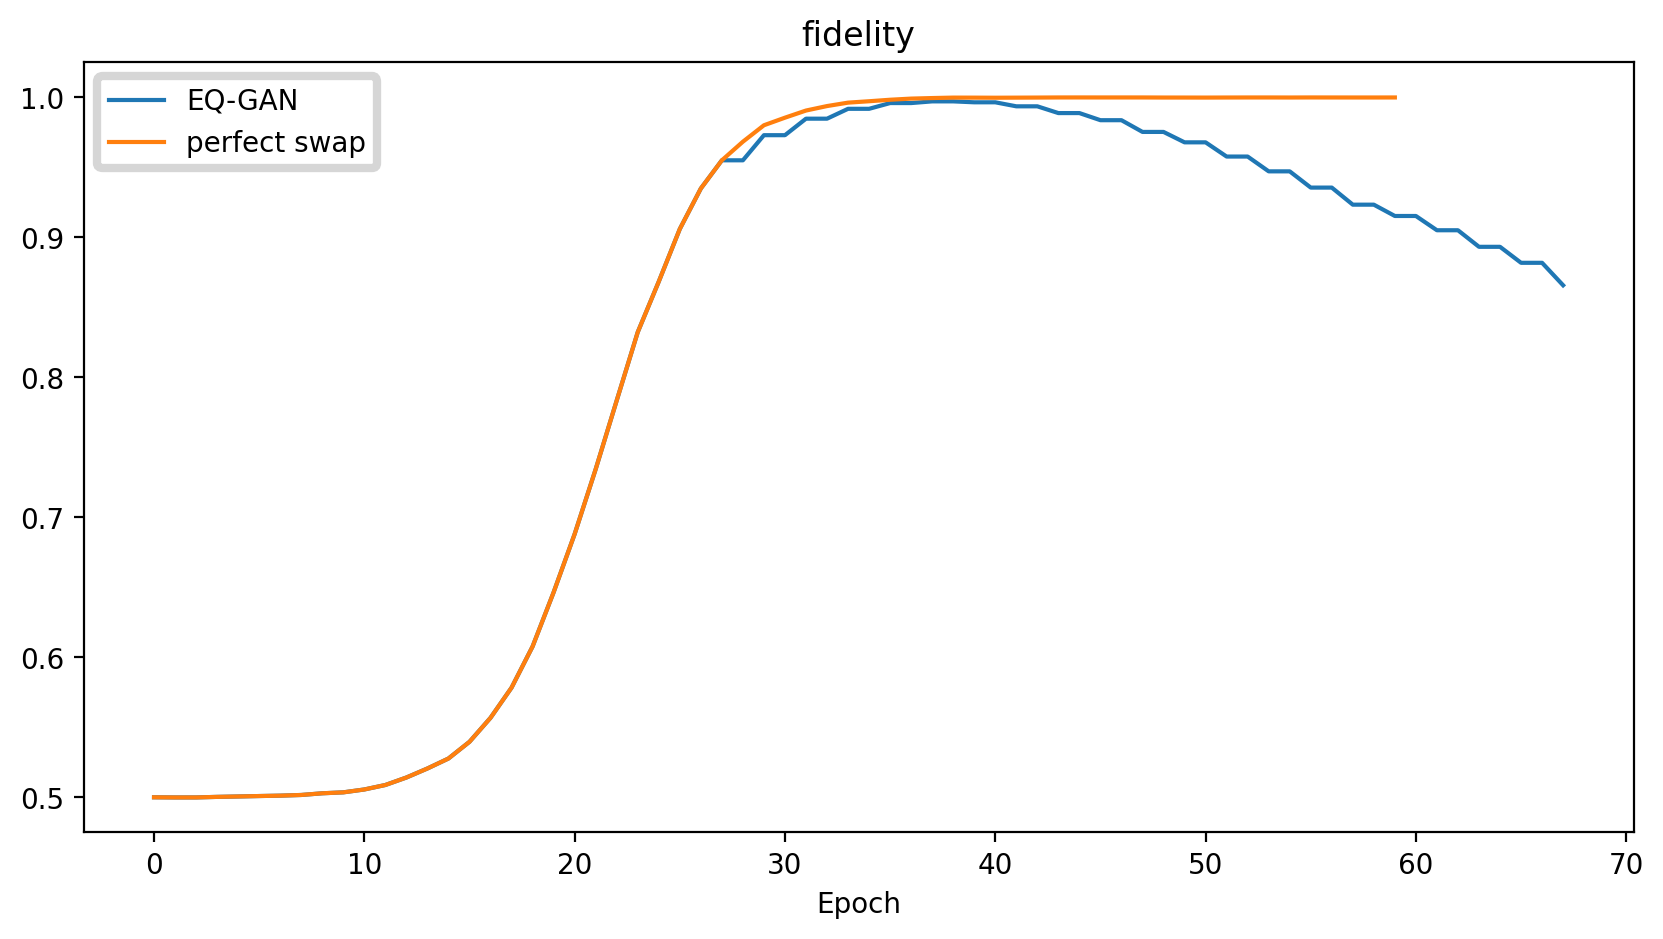

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="EQ-GAN")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [30]:
max(sg[:40])

<tf.Tensor: shape=(), dtype=float64, numpy=0.9971899240759133>

In [31]:
max(perfect_swap[:40])

<tf.Tensor: shape=(), dtype=float64, numpy=0.9998842682465644>